## High-z galaxies with Te measurements

# Determine metallicities using the direct method

In [2]:
## Global stuff
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table

colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, 16))

## Lines to be used
line_names = ['OIII1661','OIII1666','NIII1750','CIII1907','CIII1909','NeIII3869','OII3727','OII3729','OIITot',
              'Hd','Hg','OIII4363','Hb','OIII4959','OIII5007','Ha','NII6584']

#Probably there is a smart way of doing this with PyNeb
super_wav = {
    'OIII1661': 1661,
    'OIII1666': 1666,
    'NIII1750': 1750,
    'CIII1907': 1907,
    'CIII1909': 1909,
    'NeIII3869': 3869,
    'OII3727': 3727,
    'OII3729': 3729,
    'OIITot': 3729,
    'Hd': 4102,
    'Hg': 4340,
    'OIII4363': 4363,
    'Hb': 4861,
    'OIII4959': 4959,
    'OIII5007': 5007,
    'Ha': 6563,
    'NII6584': 6584
    }

# Quick look at all fluxes

In [3]:
# Load data
fluxes = Table.read('data_dered.dat',format='ascii.fixed_width_two_line')
fluxes.show_in_notebook()

idx,Name,E(B-V),eE(B-V),OIII1661,OIII1666,NIII1750,CIII1907,CIII1909,NeIII3869,OII3727,OII3729,OIITot,Hd,Hg,OIII4363,Hb,OIII4959,OIII5007,Ha,NII6584,eOIII1661,eOIII1666,eNIII1750,eCIII1907,eCIII1909,eNeIII3869,eOII3727,eOII3729,eOIITot,eHd,eHg,eOIII4363,eHb,eOIII4959,eOIII5007,eHa,eNII6584
0,CSWA20,-0.0115772969717,-0.108153772451,0.04,0.1,nan,0.12,0.11,0.37,0.47,0.52,0.47,nan,0.57,0.05,1.0,1.67,4.97,3.32,0.06,0.04,0.04,nan,0.01,0.01,0.02,0.02,0.03,0.2,nan,0.05,0.03,0.07,0.1,0.29,0.2,0.02
1,USD-12539,0.0,0.0,nan,nan,nan,nan,nan,3.29065e-17,7.35208e-17,8.08939e-17,1.544147e-16,nan,2.9366e-17,3.95775e-17,1.20361e-16,nan,5.72444e-16,4.07651e-16,1.79054e-17,nan,nan,nan,nan,nan,6.27673e-18,2.50988e-17,2.89959e-17,5.40947e-17,nan,2.29637e-18,3.30824e-18,3.69689e-18,nan,3.2338e-18,1.32121e-18,1.34166e-18
2,Abell_860_359,0.0298832077515,0.0501135303429,0.0433328367186,0.119876254353,0.0433670341057,nan,nan,nan,nan,nan,1.57823737445,nan,nan,nan,1.24639072556,2.51895239558,7.5781449423,3.49805931074,nan,nan,0.367197768332,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0987707062484,0.0945198258472,0.0944240028217,0.0840531901355,nan
3,Abell_22.3,-0.0953652097004,0.317658930585,nan,nan,nan,nan,nan,nan,nan,nan,1.11,nan,nan,0.27,1.0,1.98,6.45,5.03,0.05,nan,nan,nan,nan,nan,nan,nan,nan,0.3,nan,nan,0.1,0.1,0.3,0.3,0.4,nan
4,RCSGA,0.247280710803,0.251026588043,nan,nan,nan,nan,nan,27.3399602894,nan,nan,258.243874691,23.7219822706,42.6204878584,4.70896287308,90.4593959674,134.820901578,430.580095519,248.751934261,15.8262270695,nan,nan,nan,nan,nan,0.342931075226,nan,nan,0.298996289988,0.384659104667,0.336688257159,nan,0.305724919038,0.305612725647,0.304013801163,0.299012818124,0.339887294736
5,A1689_31.1,0.167391189014,0.296256738425,25.3829443649,58.6670153215,nan,42.1108028498,81.7688725728,29.1240735413,43.0614953066,54.7434751519,97.7896265535,nan,68.178819511,24.6962807596,147.61936625,212.4148227,704.718842682,nan,nan,0.304912361271,0.281089386132,nan,0.282394723015,0.272621063217,0.501233688224,0.324425674414,0.321900602367,0.322984499533,nan,0.343305960066,0.432529153369,0.345640262715,0.367563677487,0.328236292941,nan,nan
6,SMACS_0304,-0.0234885752537,0.169540315232,0.0454380750999,0.0746258203669,nan,nan,nan,0.7094740515,2.10553630232,2.823482071,5.04880138718,0.58849822224,0.907420039937,nan,2.02419462981,2.67210010255,9.34416314271,6.08595970771,0.195525614701,0.327745377505,0.302897994492,nan,nan,nan,12.6775509291,3.89100906755,3.33014554439,0.248898808626,0.248434528493,0.246643066283,nan,0.243037095315,0.242300391683,0.2419165493,0.229353557802,0.233179635877
7,MACS_0451,0.294450787669,-0.0688195392807,0.2,0.3,0.1,nan,nan,nan,nan,nan,0.63,nan,nan,nan,1.0,1.37,3.95,2.58,0.065,0.1,0.1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.1,0.05,0.05,0.16,nan
8,COSMOS_12805,0.243724506639,0.0747788766151,0.0604607506973,0.0925369971004,0.0518468727659,nan,nan,nan,nan,nan,3.39164036002,nan,nan,nan,1.1341568745,2.13811784752,7.29929356416,3.1184606685,0.109768911769,0.269652382998,0.22964064803,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.313528836549,0.239867119887,0.100494291963,0.0817304579985,nan
9,BX660,0.0,0.00189509394299,0.0,0.21,nan,nan,nan,nan,nan,nan,0.87,nan,nan,nan,1.0,3.2,6.4,2.77,0.07,0.0,0.04,nan,nan,nan,nan,nan,nan,0.04,nan,nan,nan,0.2,0.8,0.3,0.2,nan


## Using PyNeb/Izotov2006

In [4]:
## Temperatures from Izotov 2009
def Izotov06_TOIII(f,t):
    """ Equation 1 of Izotov 2006. Only works if OIII4663 is seen. Neglecting density.
    """
    t *= 1e-4
    CT = 8.44 - 1.09*t + 0.5*t**2 - 0.08*t**3 # Here we are neglecting the density
    new_t = 1.432 /(np.log10((f['OIII4959'] + f['OIII5007'])/f['OIII4363']) - np.log10(CT))
    return new_t * 1e4

def calculate_TOIII(f):
    
    params = Parameters()
    params.add('t', value=10000., min=1000., max=30000.)
    
    def fnc(params,f):
        t = params['t']
        return t - Izotov06_TOIII(f,t)
    
    fit = minimize(fnc, params,args=(f,),method='least_squares')
    
    return fit.params['t'].value
    
    
def Izotov06_TOII(tOIII,Z='intermediate'):
    """Equation 14 of Izotov 2006. The dispersion of this relation is not provided
    """
    tOIII *= 1e-4 
    if Z == 'low': # 7.2
        return (-0.577 + tOIII * (2.065 - 0.498*tOIII))*1e4 
    elif Z == 'intermediate': #7.6
         return (-0.744 + tOIII * (2.338 - 0.610*tOIII))*1e4 
    elif Z == 'high': # 8.2
        return (2.967 + tOIII * (-4.797 + 2.827*tOIII))*1e4 
    else:
        print('Wrong "Z" option')

In [5]:
# Calculate metallicities
import pyneb as pn
pn.atomicData.setDataFile('o_iii_coll_AK99.dat') # have to change because the default ones do not have level 6
O3 = pn.Atom('O', 3)
O2 = pn.Atom('O',2)

dered_fluxes = Table.read('data_dered.dat',format='ascii.fixed_width_two_line')
Te_data = Table.read('data_Te.dat',format='ascii.fixed_width_two_line')
Te_data.add_index('Name')

O_H_pyneb = []
O2_H_pyneb = []
met_pyneb = []

def sum_met(OH,O2H):
    return 12 + np.log10(10**(OH-12)+10**(O2H-12))

for f in dered_fluxes:
    
    Te = Te_data.loc[f['Name']]['Te']
    Den = Te_data.loc[f['Name']]['Den']
    
    #  Calculate TOII. take our estimated temperatures as TOIII.
    t_low = (Izotov06_TOII(Te,Z='low')) # May need to change the Z
    t_inter = (Izotov06_TOII(Te,Z='intermediate')) # May need to change the Z
    t_high = (Izotov06_TOII(Te,Z='high')) # May need to change the Z

    def change_scale(x):
        return 12+np.log10(x)
    
    # Calculate metalliticites
    O2_H_pyneb.append(change_scale(O3.getIonAbundance((f['OIII4959']+f['OIII5007']),Te,Den,
                                                to_eval='L(4959)+L(5007)',Hbeta=f['Hb'])))
    O_H_pyneb.append(change_scale(O2.getIonAbundance((f['OIITot']),t_inter,Den,
                                                     to_eval='L(3726)+L(3729)',Hbeta=f['Hb'])))
    met_pyneb.append(sum_met(O2_H_pyneb[-1],O_H_pyneb[-1]))
    
    a = change_scale(O2.getIonAbundance((f['OIITot']),t_low,Den, to_eval='L(3726)+L(3729)',Hbeta=f['Hb']))
    b = change_scale(O2.getIonAbundance((f['OIITot']),t_inter,Den, to_eval='L(3726)+L(3729)',Hbeta=f['Hb']))
    c = change_scale(O2.getIonAbundance((f['OIITot']),t_high,Den, to_eval='L(3726)+L(3729)',Hbeta=f['Hb']))

    print(a,b,c)
    
    
print('                Name\tO/H\tO+2/H\tMetOH')
for i,f in enumerate(dered_fluxes):
    print('%20s\t%0.2f\t%0.2f\t%0.2f'%(f['Name'],O_H_pyneb[i],O2_H_pyneb[i],met_pyneb[i]))


(7.0771393377146925, 7.0799264750987909, 7.0353937513523075)
(9.5706827279760844, nan, nan)
(7.2959253891657108, 7.2971208043750595, 7.0899292140508834)
(6.9945405976756705, 7.1917358000066747, nan)
(7.7437321140710083, 7.7448214258994605, 7.6326980969169158)
(6.7001375091550717, 6.764944748555906, nan)
(7.8751104151452784, 7.8782044282372254, 7.8388451401850459)
(6.6938578908773332, 6.7277128381869868, nan)
(7.736991958919015, 7.7379041859405397, 7.6029571907789801)
(6.954817842898823, 6.9645759563940492, 6.4506353178907849)
(7.1398888353511358, 7.1467829417368334, 6.6950549978719378)
(7.0700591061666254, 7.0730744610167928, 6.7521994301680222)
(7.7478054424586089, 7.7487725852343488, 7.6233900667591081)
(6.809848075150688, 6.8134813166196233, 6.468830519069293)
(7.6328850218725641, 7.6519596101127227, 7.5780644267711672)
                Name	O/H	O+2/H	MetOH
              CSWA20	7.08	8.10	8.14
           USD-12539	nan	nan	nan
       Abell_860_359	7.30	8.02	8.09
          Abell_22.3	7.

# How to get an error using Pyned? 

Using MC? 

    1) Draw an E(B-V)
    2) Dered the lines
    3) Draw a temperature and a density
    4) Calculate the metalllicity

repeat for a couple of times?

In [6]:
# Calculate metallicities with error estimation
from astropy.visualization import hist
import pickle
galaxies = Table.read('data_dered.dat',format='ascii.fixed_width_two_line')

O_H_pyneb = []
O2_H_pyneb = []
met_pyneb = []
upO_H_pyneb = []
upO2_H_pyneb = []
upmet_pyneb = []
lowO_H_pyneb = []
lowO2_H_pyneb = []
lowmet_pyneb = []

def change_scale(x):
    return 12+np.log10(x)

print('                Name\t       O/H\t\t       O+2/H\t\t      MetOH')
for gal in galaxies:
    
    # Open flux files
    dered_f = pickle.load( open( 'dered_f_samples/'+gal['Name']+"_flux_samples.pickle", "rb" ) )
    O2_H_sample = []
    O_H_sample = []
    
    #  Sample of densitties and TOIII. Calculate TOII
    tem_and_den    = pickle.load( open( 'tem_and_ebv_samples/'+gal['Name']+"_tem_and_ebv.pickle", "rb" ) )
    tOIII_sample  = np.random.choice(tem_and_den['tem'], len(dered_f['Hb']))#np.full_like(dered_f['Hb'],gal['Te'])
    den_sample    = np.random.choice(tem_and_den['den'], len(dered_f['Hb']))#np.full_like(dered_f['Hb'],gal['Den'])  
    tOII_sample   = np.array([Izotov06_TOII(x,Z='low') for x in tOIII_sample]) # May need to change the Z
    
    ## Calculate metalliticites
    O2_H_sample.append(O3.getIonAbundance(np.array(dered_f['OIII4959'])+np.array(dered_f['OIII5007']),
                                          tOIII_sample,den_sample,to_eval='L(4959)+L(5007)',Hbeta=dered_f['Hb']))
    O_H_sample.append(O2.getIonAbundance(np.array(dered_f['OIITot']),
                                          tOII_sample,den_sample,
                                          to_eval='L(3726)+L(3729)',Hbeta=dered_f['Hb']))
    
    total = np.array([change_scale(m1+m2) for  m1,m2 in zip(O2_H_sample,O_H_sample)])
    O2_H_sample = np.array([change_scale(m) for  m in O2_H_sample])
    O_H_sample  = np.array([change_scale(m) for  m in O_H_sample])
    
    O2_H_pyneb.append(np.nanpercentile(O2_H_sample,50))
    O_H_pyneb.append(np.nanpercentile(O_H_sample,50)) 
    upO2_H_pyneb.append(np.nanpercentile(O2_H_sample,84)-np.nanpercentile(O2_H_sample,50))
    upO_H_pyneb.append(np.nanpercentile(O_H_sample,84)-np.nanpercentile(O_H_sample,50))
    lowO2_H_pyneb.append(np.nanpercentile(O2_H_sample,50)-np.nanpercentile(O2_H_sample,16))
    lowO_H_pyneb.append(np.nanpercentile(O_H_sample,50)-np.nanpercentile(O_H_sample,16))
    met_pyneb.append(np.nanpercentile(total,50))
    upmet_pyneb.append(np.nanpercentile(total,84)-np.nanpercentile(total,50))
    lowmet_pyneb.append(np.nanpercentile(total,50)-np.nanpercentile(total,16))

    print('%20s\t%0.2f + %0.2f - %0.2f\t%0.2f + %0.2f - %0.2f\t%0.2f + %0.2f - %0.2f'%(gal['Name'],
                                                               O_H_pyneb[-1],upO_H_pyneb[-1],lowO_H_pyneb[-1],
                                                               O2_H_pyneb[-1],upO2_H_pyneb[-1],lowO2_H_pyneb[-1],
                                                              met_pyneb[-1],upmet_pyneb[-1],lowmet_pyneb[-1]))


                Name	       O/H		       O+2/H		      MetOH
              CSWA20	6.98 + 0.51 - 0.24	8.08 + 0.38 - 0.22	8.12 + 0.39 - 0.22
           USD-12539	8.93 + 2.96 - 1.17	nan + nan - nan	nan + nan - nan
       Abell_860_359	7.30 + 0.11 - 0.09	8.02 + 0.10 - 0.09	8.10 + 0.10 - 0.09
          Abell_22.3	7.18 + 0.35 - 0.23	7.40 + 0.14 - 0.12	7.60 + 0.12 - 0.06
               RCSGA	7.74 + 0.09 - 0.08	7.99 + 0.05 - 0.04	8.19 + 0.05 - 0.05
          A1689_31.1	6.75 + 0.15 - 0.16	7.41 + 0.23 - 0.14	7.49 + 0.21 - 0.09
          SMACS_0304	7.90 + 0.20 - 0.10	8.07 + 0.06 - 0.05	8.29 + 0.12 - 0.06
           MACS_0451	6.68 + 0.10 - 0.07	7.47 + 0.14 - 0.17	7.53 + 0.13 - 0.14
        COSMOS_12805	7.73 + 0.36 - 0.30	8.09 + 0.23 - 0.31	8.26 + 0.25 - 0.30
               BX660	6.95 + 0.20 - 0.21	7.90 + 0.16 - 0.20	7.96 + 0.16 - 0.18
                BX74	7.16 + 0.29 - 0.25	7.94 + 0.25 - 0.26	8.03 + 0.24 - 0.27
               BX418	7.08 + 0.31 - 0.27	7.98 + 0.20 - 0.21	8.03 + 0.20 - 0.21
           

In [7]:
## Save results in a table 
pyneb_out = Table([dered_fluxes['Name'],
                   O_H_pyneb,upO_H_pyneb,lowO_H_pyneb,
                   O2_H_pyneb,upO2_H_pyneb,lowO2_H_pyneb,
                   met_pyneb,upmet_pyneb,lowmet_pyneb],
                names = ['Name','O/H','upO/H','lowO/H','O2/H','upO2/H','lowO2/H','met','upmet','lowmet'])

pyneb_out.write('pyneb_Te_method.dat',format='ascii.fixed_width_two_line')
pyneb_out.show_in_notebook() 

idx,Name,O/H,upO/H,lowO/H,O2/H,upO2/H,lowO2/H,met,upmet,lowmet
0,CSWA20,6.98392650705,0.512913355086,0.236914359111,8.08129528564,0.381074745965,0.218940031979,8.11564700257,0.391058454897,0.218767439993
1,USD-12539,8.92956775148,2.96087558768,1.17497009379,nan,nan,nan,nan,nan,nan
2,Abell_860_359,7.29668030034,0.112160492415,0.0904140964741,8.02089731701,0.0983580399278,0.0875359465493,8.09675060485,0.0999000697647,0.0887632626548
3,Abell_22.3,7.17667782275,0.351196438864,0.233491324582,7.40380041067,0.142072685579,0.115569992204,7.59667736902,0.118771916938,0.0632561186175
4,RCSGA,7.7424536272,0.0920757725273,0.0794853277945,7.99187813013,0.0459963373139,0.0437563678991,8.18956024228,0.0511261116555,0.0502298940053
5,A1689_31.1,6.74896371787,0.150023114038,0.160020228296,7.4075843197,0.231238638885,0.144932191498,7.48716256892,0.207637916011,0.0877520706955
6,SMACS_0304,7.89773722421,0.202074165397,0.0967089549656,8.06564114983,0.0615658917569,0.0454302458245,8.29439813514,0.12186630501,0.0618385419088
7,MACS_0451,6.68221484696,0.101066000328,0.0703052980167,7.4660594234,0.136385319152,0.167762598351,7.52791257727,0.132621027913,0.137188120077
8,COSMOS_12805,7.73021235073,0.355316176191,0.303690787063,8.09422981229,0.227251492669,0.314227114653,8.26150510592,0.251891395099,0.295491382772
9,BX660,6.95457595658,0.195743569133,0.210773585561,7.90415187967,0.163034969922,0.200046681183,7.95756393714,0.162921646156,0.179309580624


In [8]:
## Write it to paper 

out = open('TeMethod_pyneb_for_paper','w')

out.write('Obj          \t& 12+log (O$^+$/H$^+$) \t& 12+log(O$^{2+}$/H$^+$) \t& 12+log(O/H)$_{\Te}$ \\\\ \n')

for f in pyneb_out:
    out.write("%s \t& %0.2f$^{+%0.2f}_{-%0.2f}$\t& %0.2f$^{+%0.2f}_{-%0.2f}$\t& %0.2f$^{+%0.2f}_{-%0.2f}$\t \\\\ \n"
                  %(f['Name'],f['O/H'],f['upO/H'],f['lowO/H'],
                    f['O2/H'],f['upO2/H'],f['lowO2/H'],
                    f['met'],f['upmet'],f['lowmet']))
                    
out.close()

<IPython.core.display.Javascript object>


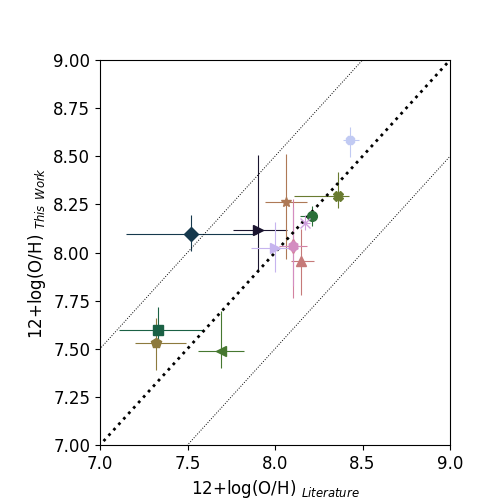

In [18]:
# Compare with previous estimations
plt.rcParams.update({'font.size': 12})
properties = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line')
properties.add_index('Name')

## colors and markers
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, len(properties['Name'])))
properties.remove_row(3)

#plotting
fig, ax = plt.subplots(1,1,figsize=(5,5))
fig.subplots_adjust(left=0.2)

for i,gal in enumerate(properties):    
    ax.errorbar(gal['MetTe'],met_pyneb[i],label=gal['Name'],
                xerr=np.array((np.abs(gal['infMetTe']),gal['supMetTe'])).reshape(2,1),
                yerr=np.array((lowmet_pyneb[i],upmet_pyneb[i])).reshape(2,1),
                color=colors[gal['nb']],marker=gal['marker'],
                markersize=7,elinewidth=0.8)

ax.plot(np.arange(6.0,10.),np.arange(6.0,10.),color='k',linewidth=2.0,linestyle=':')
ax.plot(np.arange(6.0,10.),np.arange(6.0,10.)+0.5,color='k',linewidth=0.7,linestyle=':')
ax.plot(np.arange(6.0,10.),np.arange(6.0,10.)-0.5,color='k',linewidth=0.7,linestyle=':')
ax.set_ylabel('12+log(O/H) $_{This\,\,\,Work}$')
ax.set_xlabel('12+log(O/H) $_{Literature}$')
ax.set_ylim(7.0,9.0)
ax.set_xlim(7.0,9.0)

fig.savefig('/Users/vera/Desktop/DirectMethod_Lit.pdf')
